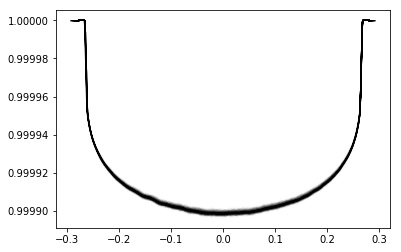

In [190]:
%matplotlib inline
import astropy.units as u
from astropy.constants import R_earth, R_sun
from sunpy.map import Map
from stash import simulate_lightcurve
import matplotlib.pyplot as plt
from astropy.io import fits
from glob import glob

paths = glob('decon/*.fits')

# Set up planet parameters
orbital_period = 365 * u.day
semimajor_axis = 1 * u.AU
impact_parameter = 0.0
R_planet = R_earth
R_star = R_sun
lightcurves = []

for path in paths[3:]:
    f = fits.open(path, memmap=False, lazy_load_hdus=True)
    f[1].verify('silentfix')

    # Simulate a light curve for that system, return a `LightCurve` object
    lc = simulate_lightcurve(f[1].data, orbital_period, semimajor_axis,
                             impact_parameter, R_planet, R_star)

    if lc.times.min() < -0.4: 
        pass

    else: 
        # Plot the resulting light curve
        lc.plot(alpha=0.01, color='k')
        lightcurves.append(lc)

plt.gca().ticklabel_format(useOffset=False)
# Show me the plot!
plt.show()

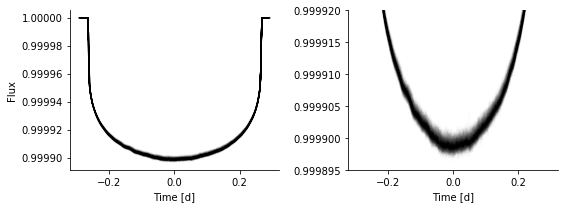

In [191]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for lc in lightcurves: 
    
    lc.plot(ax=ax[0], alpha=0.01, color='k')

    lc.plot(ax=ax[1], alpha=0.01, color='k')

    
ax[0].ticklabel_format(useOffset=False)
ax[0].set_xlabel('Time [d]')
ax[0].set_ylabel('Flux')

ax[1].set_ylim([0.999895, 0.99992])
ax[1].set_xlabel('Time [d]')
fig.tight_layout()

for axis in ax: 
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)

plt.savefig('paper_plots/lc.pdf', bbox_inches='tight')
# Show me the plot!
plt.show()

In [192]:
len(lightcurves)

268

In [262]:
from batman import TransitParams
import numpy as np

params = TransitParams()
params.per = 365
params.rp = float(R_earth/R_sun)
params.a = float(1*u.AU/R_sun)
params.inc = 90

# Sing 2009: https://arxiv.org/pdf/0912.2274.pdf
params.u = [0.6283, -0.3063, 0.8965, -0.4593] #[0.45, 0.0, 0.19, 0.0]
params.limb_dark = "nonlinear"
params.ecc = 0
params.w = np.pi/2
params.t0 = 0

In [264]:
# residuals = []
# for lc in lightcurves:
#     try: 
#         transit_model = lc.get_transit_model(params, 1e-6)
     
#         residuals.append(lc.fluxes - transit_model.fluxes)
#     except Exception:
#         pass

In [623]:
import emcee
import batman 
from copy import deepcopy

def transit_model(p):
    rp, t0, inc, u1, u2, u3, u4 = p
    
    trial_params = deepcopy(params)
    trial_params.rp = rp
    trial_params.t0 = t0
    trial_params.inc = inc
    trial_params.u1 = u1
    trial_params.u2 = u2
    trial_params.u3 = u3
    trial_params.u4 = u4   
    
    m = batman.TransitModel(trial_params, lightcurves[0].times, supersample_factor=3, 
                            exp_time=lightcurves[0].times[1]-lightcurves[0].times[0])
    return m.light_curve(trial_params)


cropped_residuals = np.load('cropped_residuals.npy')
correction = np.median(cropped_residuals, axis=0)

for lc in lightcurves[0:1]: 
    
    def lnlike(p, yerr=0.6e-6):
        
        rp, t0, u1, u2, u3, u4 = p
        ld_params = np.array([u1, u2, u3, u4])
        if np.any(ld_params > 1) or np.any(ld_params < -1) or inc > 90:
            return -np.inf
        
        return -0.5 * np.sum((transit_model(p) - lc.fluxes - correction)**2 / yerr**2)
    
    nwalkers, ndim = 14, 7
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, threads=4)
    
    initp = [np.array([params.rp, params.t0, params.inc, params.u[0], params.u[1], params.u[2], params.u[3]])
             + 1e-5 * np.random.randn(ndim) for _ in range(nwalkers)]
    
    print('burn in...')
    p0 = sampler.run_mcmc(initp, 1000)[0]
    sampler.reset()
    print('production...')
    sampler.run_mcmc(p0, 1000)

burn in...


/Users/bmmorris/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/bmmorris/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


production...


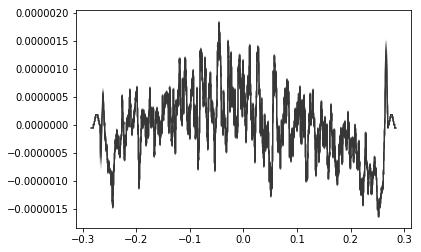

(array([ 12.,  15.,  15.,  13.,  12.,  12.,   6.,   4.,   6.,   5.]),
 array([ 0.91640872,  0.91701678,  0.91762485,  0.91823292,  0.91884098,
         0.91944905,  0.92005712,  0.92066518,  0.92127325,  0.92188131,
         0.92248938]),
 <a list of 10 Patch objects>)

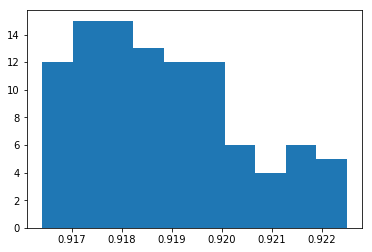

In [624]:
# lc.plot()
chi2 = []
for _ in range(100): 
    i = np.random.randint(0, sampler.flatchain.shape[0])
    model = transit_model(sampler.flatchain[i, :])
    
    plt.plot(lc.times, lc.fluxes - model - correction, alpha=0.01, color='k')

    chi2.append(np.sum((lc.fluxes - model - correction)**2 / 0.6e-6**2) / len(lc.fluxes))
    
plt.show()

plt.hist(chi2)

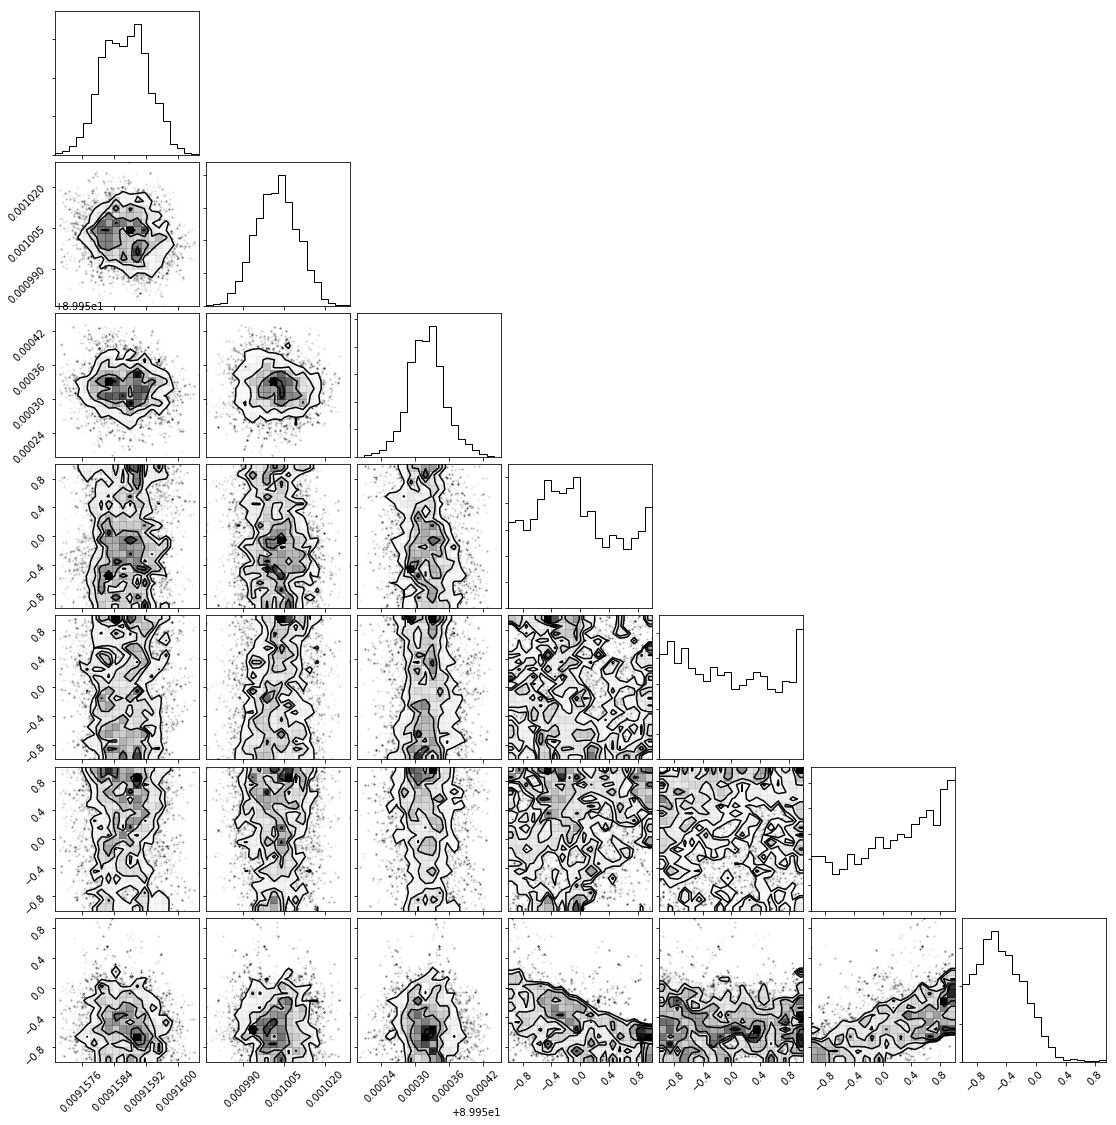

In [625]:
corner(sampler.flatchain);
plt.show()

In [606]:
np.abs(sampler.flatchain[:, 0].mean() - float(R_earth/R_sun))/sampler.flatchain[:, 0].std()

8.2024675475965054

In [626]:
sampler.flatchain[:, 0].std()/sampler.flatchain[:, 0].mean()

6.2043246788708395e-05

In [196]:
residuals = np.array(residuals)

In [197]:
cropped_residuals = residuals[np.max(residuals, axis=1) < 5e-6]

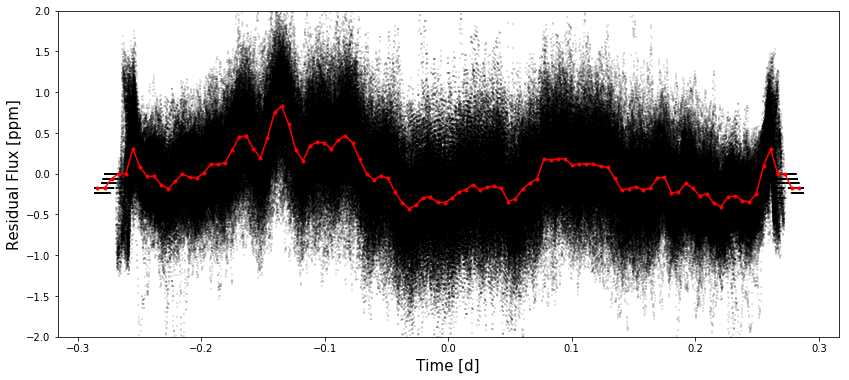

In [198]:
plt.figure(figsize=(14, 6))
for r in cropped_residuals:
    if r.max() < 5e-6:
        plt.scatter(transit_model.times, r*1e6, marker=',', color='k', s=1, alpha=0.1)

from scipy.stats import binned_statistic 

bs = binned_statistic(np.tile(transit_model.times, cropped_residuals.shape[0]), 
                      cropped_residuals.ravel(), statistic='median', bins=100)
bincenters = 0.5 * (bs.bin_edges[:-1] + bs.bin_edges[1:])
plt.plot(bincenters, 1e6 * bs.statistic, color='r', marker='.')
        
fontsize = 15
plt.xlabel('Time [d]', fontsize=fontsize)
plt.ylabel('Residual Flux [ppm]', fontsize=fontsize)
plt.ylim([-2, 2])
plt.savefig('residuals_decon.png', bbox_inches='tight', dpi=250)

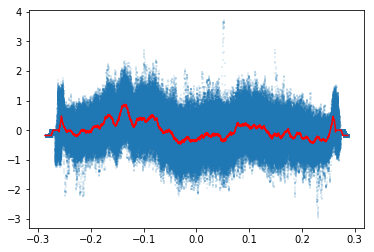

In [199]:
plt.scatter(np.tile(transit_model.times, cropped_residuals.shape[0]), 1e6*cropped_residuals, marker=',', s=1, alpha=0.1)
plt.plot(transit_model.times, 1e6*np.median(cropped_residuals, axis=0), 'r')

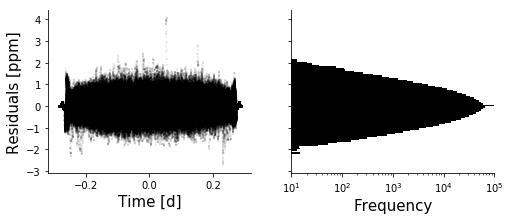

In [208]:
corrected_residuals = 1e6*(cropped_residuals - np.median(cropped_residuals, axis=0))

fontsize = 15
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
ax[0].scatter(np.tile(transit_model.times, cropped_residuals.shape[0]), corrected_residuals, 
              marker=',', s=1, alpha=0.05, rasterized=True, color='k')
ax[1].hist(corrected_residuals.ravel(), orientation='horizontal', 
           bins=100, log=True, histtype='stepfilled', color='k')

for axis in ax: 
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
# ax[1].spines['bottom'].set_visible(False)
# # ax[1].set_xticks([])
ax[1].set_xlim([1e1, 1e5])
ax[0].set_xlabel('Time [d]', fontsize=fontsize)
ax[0].set_ylabel('Residuals [ppm]', fontsize=fontsize)
ax[1].set_xlabel('Frequency', fontsize=fontsize)

fig.savefig('paper_plots/corrected_residuals.pdf', bbox_inches='tight', dpi=300)
plt.show()

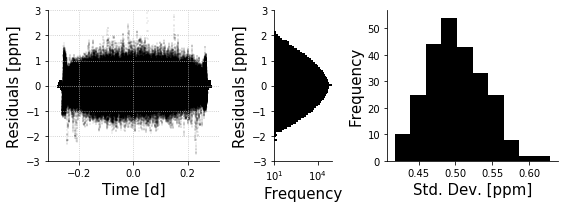

In [546]:
corrected_residuals = 1e6*(cropped_residuals - np.median(cropped_residuals, axis=0))

fontsize = 15
# fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 3))
gs = GridSpec(1, 5, figure=fig)

ax0 = plt.subplot(gs[0:2])

ax1 = plt.subplot(gs[2])

ax2 = plt.subplot(gs[3:5])

ax0.scatter(np.tile(lightcurves[0].times, cropped_residuals.shape[0]), corrected_residuals, 
              marker=',', s=1, alpha=0.05, rasterized=True, color='k')
ax0.grid(ls=':', color='silver')

ax1.hist(corrected_residuals.ravel(), orientation='horizontal', 
           bins=100, log=True, histtype='stepfilled', color='k')

ax2.hist(1e6*cropped_residuals.std(axis=1), histtype='stepfilled', color='k')

ax2.set_xlabel('Std. Dev. [ppm]', fontsize=fontsize)
ax2.set_ylabel('Frequency', fontsize=fontsize)

for axis in [ax0, ax1, ax2]: 
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
# ax[1].spines['bottom'].set_visible(False)
# # ax[1].set_xticks([])
ax1.set_xlim([1e1, 1e5])
ax0.set_ylim([-3, 3])
ax1.set_ylim([-3, 3])

ax0.set_xlabel('Time [d]', fontsize=fontsize)
ax0.set_ylabel('Residuals [ppm]', fontsize=fontsize)
ax1.set_ylabel('Residuals [ppm]', fontsize=fontsize)
ax1.set_xlabel('Frequency', fontsize=fontsize)

fig.tight_layout()
fig.savefig('paper_plots/corrected_residuals.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [327]:
corrected_residuals.ravel().std()

0.42723918955872914

(array([ 15.,  45.,  71.,  66.,  29.,   9.,   5.,   2.,   2.,   2.]),
 array([ 0.35551248,  0.37849802,  0.40148357,  0.42446911,  0.44745465,
         0.47044019,  0.49342573,  0.51641127,  0.53939681,  0.56238235,
         0.58536789]),
 <a list of 10 Patch objects>)

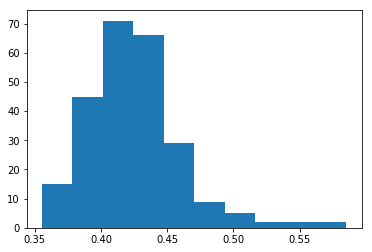

In [324]:
plt.hist(corrected_residuals.std(axis=1))

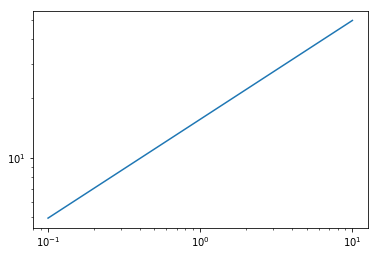

In [294]:
# prefactor = np.linalg.inv( A.T @ C_inv @ A ) @ A.T @ C_inv
# error = np.sqrt(np.linalg.inv( A.T @ C_inv @ A )[0, 0])

yerrs = np.logspace(-7, -4, 10)  
errors = []
for yerr in yerrs: 
    # Hogg 2010 
    A = np.ones_like(r)[:, np.newaxis]
    C = np.diag(yerr * np.ones_like(r))
    C_inv = np.linalg.inv(C)
    error = np.sqrt(np.linalg.inv( A.T @ C_inv @ A )[0, 0])
    errors.append(error)
    
plt.loglog(yerrs*1e6, 1e6 * np.array(errors))

In [298]:
yerr = 1e-7
A = np.ones_like(r)[:, np.newaxis]
C = np.diag(yerr**2 * np.ones_like(r))
C_inv = np.linalg.inv(C)
error = np.sqrt(np.linalg.inv( A.T @ C_inv @ A )[0, 0])
error

1.5694120514358609e-09

In [270]:
from astropy.stats import mad_std
corrected_residuals.ravel().ptp()

6.828389183033412

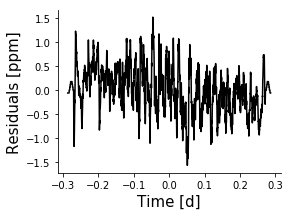

In [248]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(transit_model.times, corrected_residuals[0], color='k')
ax.set_xlabel('Time [d]', fontsize=fontsize)
ax.set_ylabel('Residuals [ppm]', fontsize=fontsize)
for s in ['right', 'top']:
    ax.spines[s].set_visible(False)
fig.savefig('paper_plots/example_residuals.pdf', bbox_inches='tight')
plt.show()

Running burn-in...
Running production...
0.0347440534039


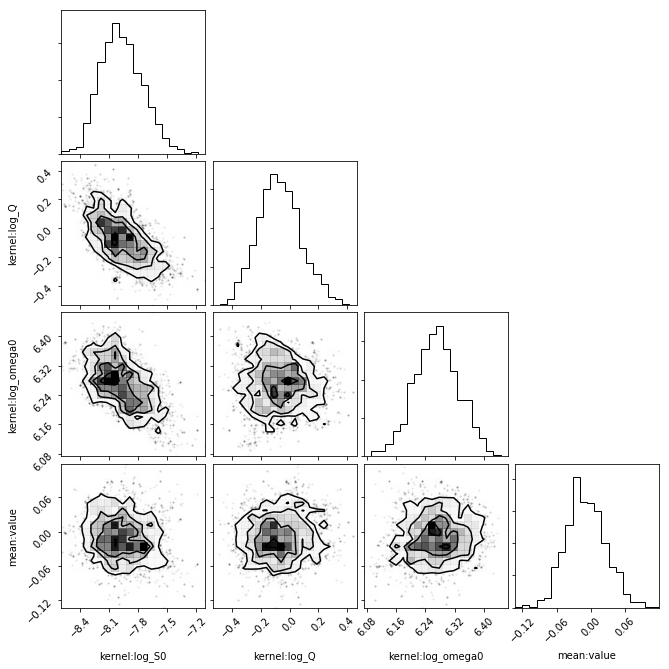

In [512]:
import celerite
from celerite import terms
import emcee

bounds = dict(log_S0=(-15, 0), log_Q=(-15, 15), log_omega0=(-10, 10))
kernel = terms.SHOTerm(log_S0=-1, log_Q=0, log_omega0=0, bounds=bounds)

for r in corrected_residuals[0:1]:
    x, y = lc.times, r + 0.1 * np.random.randn(len(r))

    y -= np.polyval(np.polyfit(x, y, 2), x)


    gp = celerite.GP(kernel, fit_mean=True, fit_white_noise=True)
    gp.compute(x, yerr=np.std(y))

    def log_probability(params):
        gp.set_parameter_vector(params)
        lp = gp.log_prior()
        if not np.isfinite(lp):
            return -np.inf
        return gp.log_likelihood(y) + lp

    initial = np.array([-7, -0, 6.2, 0])
    ndim, nwalkers = len(initial), 10
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

    print("Running burn-in...")
    p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
    p0 = sampler.run_mcmc(p0, 1500)[0]

    print("Running production...")
    sampler.reset()
    sampler.run_mcmc(p0, 500);
    
    print(sampler.flatchain[:, -1].std())
    
    corner(sampler.flatchain, labels=gp.get_parameter_names())
    plt.show()

Running burn-in...
Running production...
0.00166212047712


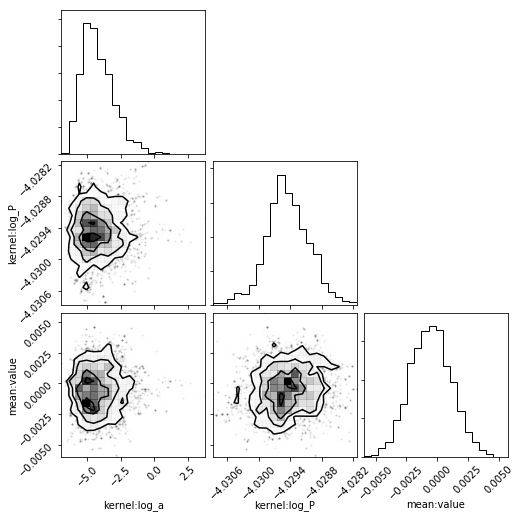

In [494]:
class CustomTermNoDecay(terms.Term):
    """Non-decaying cosine"""

    parameter_names = ("log_a", "log_P")

    def get_complex_coefficients(self, params):
        log_a, log_P = params
        return (
            np.exp(log_a), 0,
            0, 2*np.pi*np.exp(-log_P),
        )

import celerite
from celerite import terms
import emcee

bounds = dict(log_a=(-15, 15), log_P=(-10, 10))
kernel = CustomTermNoDecay(log_a=-1, log_P=np.log(0.001), bounds=bounds)

for r in corrected_residuals[0:1]:
    x, y = lc.times, r #+ 0.1 * np.random.randn(len(r))
    
    y -= np.polyval(np.polyfit(x, y, 2), x)

    gp = celerite.GP(kernel, fit_mean=True, fit_white_noise=True)
    gp.compute(x, yerr=0.1)

    def log_probability(params):
        gp.set_parameter_vector(params)
        lp = gp.log_prior()
        if not np.isfinite(lp):
            return -np.inf
        return gp.log_likelihood(y) + lp

    initial = np.array([-2, -4, 0])
    ndim, nwalkers = len(initial), 10
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

    print("Running burn-in...")
    p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
    p0 = sampler.run_mcmc(p0, 1500)[0]

    print("Running production...")
    sampler.reset()
    sampler.run_mcmc(p0, 500);
    
    print(sampler.flatchain[:, -1].std())
    
    corner(sampler.flatchain, labels=gp.get_parameter_names())
    plt.show()

Running burn-in...
Running production...
0.0171846389694


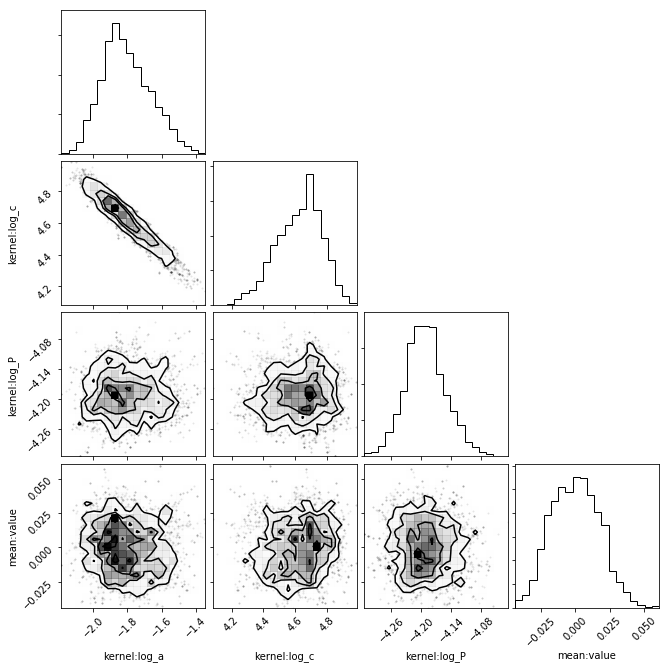

In [533]:
class CustomTerm(terms.Term):
    """Decaying exponential"""
    parameter_names = ("log_a", "log_c", "log_P")

    def get_complex_coefficients(self, params):
        log_a, log_c, log_P = params
        return (
            np.exp(log_a), 0,
            np.exp(log_c), 2*np.pi*np.exp(-log_P),
        )
    
import celerite
from celerite import terms
import emcee

bounds = dict(log_a=(-15, 15), log_c=(-15, 15), log_P=(-10, 10))
kernel = CustomTerm(log_a=-1, log_c=0, log_P=np.log(0.001), bounds=bounds)

for r in corrected_residuals[0:1]:
    x, y = lc.times, r # + 0.1 * np.random.randn(len(r))
    
    y -= np.polyval(np.polyfit(x, y, 3), x)

    gp = celerite.GP(kernel, fit_mean=True, fit_white_noise=True)
    gp.compute(x, yerr=0.1)

    def log_probability(params):
        gp.set_parameter_vector(params)
        lp = gp.log_prior()
        if not np.isfinite(lp):
            return -np.inf
        return gp.log_likelihood(y) + lp

    initial = np.array([-2, 4.5, -4, 0])
    ndim, nwalkers = len(initial), 10
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

    print("Running burn-in...")
    p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
    p0 = sampler.run_mcmc(p0, 1500)[0]

    print("Running production...")
    sampler.reset()
    sampler.run_mcmc(p0, 500);
    
    print(sampler.flatchain[:, -1].std())
    
    corner(sampler.flatchain, labels=gp.get_parameter_names())
    plt.show()

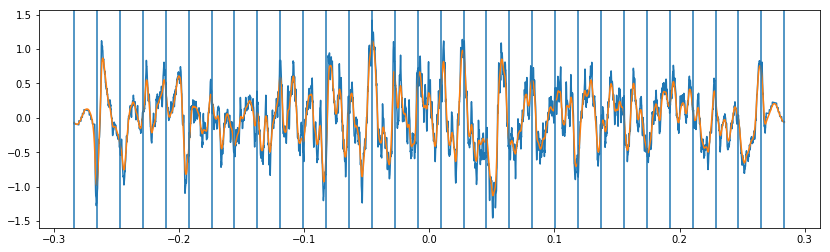

In [534]:
gp = celerite.GP(kernel)
gp.set_parameter_vector(np.median(sampler.flatchain, axis=0)[:-1])
gp.compute(x, yerr=0.5)

mu = gp.predict(y, return_cov=False)

plt.figure(figsize=(14, 4))
plt.plot(x, y)
plt.plot(lightcurves[0].times, mu)

for t in np.linspace(lightcurves[0].times.min(), lightcurves[0].times.max(), 32):
    plt.axvline(t)

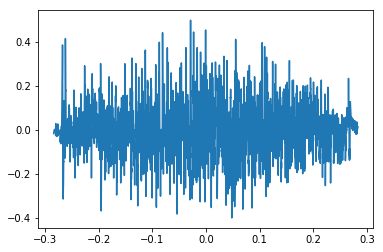

In [535]:
plt.plot(x, y - mu)

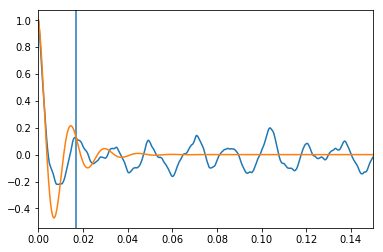

In [536]:
from interpacf import autocorrelation, interpolated_acf

acf = autocorrelation(y)
lags = np.arange(len(acf)) * (lightcurves[0].times[1] - lightcurves[0].times[0])

plt.plot(lags, acf/acf.max())
# plt.ylim([-0.2, 0.3])
plt.xlim([0, 0.15])
plt.axvline(0.017)

model_acf = gp.kernel.get_value(lags)

plt.plot(lags, model_acf/model_acf.max())

Finding optimal frequency:
 - Estimated peak width = 11.1
 - Using 5 steps per peak; omega_step = 2.22
 - User-specified period range:  0.001 to 0.2
 - Computing periods at 2824 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
0.0168590238311


/Users/bmmorris/anaconda/lib/python3.5/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


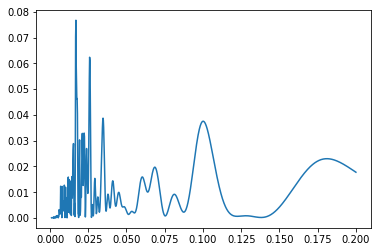

In [539]:
from gatspy.periodic import LombScargleFast

model = LombScargleFast()
model.optimizer.period_range = [0.001, 0.2]
model.fit(x, y)

print(model.best_period)

periods = np.linspace(model.optimizer.period_range[0], model.optimizer.period_range[1], 1000)
scores = model.score(periods)
plt.plot(periods, scores)
# plt.xlim([0.0001, 0.0002])

In [442]:
(0.0168 * u.day).to(u.hour)

<Quantity 0.4032 h>

In [544]:
delta_t = 2*np.pi/np.exp(6) * u.day

v = 2*np.pi*1*u.AU / (365 * u.day)

(delta_t*v).to(u.Mm)

<Quantity 40.10748159569743 Mm>

In [545]:
delta_t = np.exp(-4.20) * u.day

v = 2*np.pi*1*u.AU / (365 * u.day)

(delta_t*v).to(u.Mm)

<Quantity 38.61673856127522 Mm>

In [540]:
delta_t = model.best_period * u.day

v = 2*np.pi*1*u.AU / (365 * u.day)

(delta_t*v).to(u.Mm)

<Quantity 43.4155033500272 Mm>

In [203]:
np.save('cropped_residuals.npy', cropped_residuals)

In [204]:
np.save('corrected_residuals.npy', corrected_residuals)